# Data Analysis and Visualization of Panama City's Restaurants Based on Degusta Profiles

[Degusta Panama](https://www.degustapanama.com/) is a website dedicated to reviews of Panamanian restaurants. I believe it's an awesome site due to its very active community and its thorough database of Panamanian restaurants. The way it works is that users can give reviews to restaurants based on 3 categories: Food, Service and atmosphere. Restaurants are divided into various categories including Pricing, Location and Cuisine. All of these will provide useful for my analysis. Using restaurant data collected from the website, I'll analyze it and use it to generate some visualizations revealing user and local trends. I will be focusing on the Panama City area, since it's the only major city in Panama. All other restaurants across the country are spread out and often lack reviews. 

All of the data has already been scraped and cleaned for use for this notebook. 

## Data Preparation

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [28]:
df = pd.read_csv('..\\..\\data\\processed\\restaurants.csv', header=None, encoding='utf-8')
df = df.drop(df.columns[0], axis=1)
df.columns = ['Name', 'Type', 'Area', 'Neighborhood', 'Address', 'Lat', 'Long', 'Price', 'Comida_rating', 'Servicio_rating', 'Ambiente_rating', 'Votes', 'Menu_ejecutivo', 'Acceso_discapacitados', 'Estacionamientos', 'Kosher', 'Wifi', 'Domicilio', 'Dog_friendly']

In [29]:
df.Type = df.Type.apply(lambda x: [s.strip() for s in str(x).split(',')] if pd.notnull(x) else np.nan)
df.Price = df.Price.apply(lambda x: np.nan if x == 0 else x)
df.Comida_rating = df.Comida_rating.apply(lambda x: np.nan if x == 0 else x)
df.Servicio_rating = df.Servicio_rating.apply(lambda x: np.nan if x == 0 else x)
df.Ambiente_rating = df.Ambiente_rating.apply(lambda x: np.nan if x == 0 else x)

First, we want to limit the data to restaurants located in Panama City. 

In [30]:
lat = (8.94, 9.05)
long = (-79.6, -79.45)

city = df[(df['Lat'] > lat[0]) & (df['Lat'] < lat[1]) & (df['Long'] > long[0]) & (df['Long'] < long[1])]
city.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 2851
Data columns (total 19 columns):
Name                     1744 non-null object
Type                     1716 non-null object
Area                     1744 non-null object
Neighborhood             1743 non-null object
Address                  1743 non-null object
Lat                      1744 non-null float64
Long                     1744 non-null float64
Price                    1679 non-null float64
Comida_rating            1679 non-null float64
Servicio_rating          1679 non-null float64
Ambiente_rating          1679 non-null float64
Votes                    1744 non-null int64
Menu_ejecutivo           1744 non-null int64
Acceso_discapacitados    1744 non-null int64
Estacionamientos         1744 non-null int64
Kosher                   1744 non-null int64
Wifi                     1744 non-null int64
Domicilio                1744 non-null int64
Dog_friendly             1744 non-null int64
dtypes: float64(6), i

We end up with a total of 1744 restaurants. The Price and Rating columns have missing crucial values, so we will have to remove these in the future fbefore we perform our analysis.

In [31]:
city.describe().iloc[:,:7]

,Lat,Long,Price,Comida_rating,Servicio_rating,Ambiente_rating,Votes
count,1744.000000,1744.000000,1679.000000,1679.000000,1679.000000,1679.00000,1744.000000
mean,8.991518,-79.519617,16.755807,4.284217,4.110363,3.94997,244.426032
std,0.020960,0.022823,8.662039,0.414611,0.484307,0.55857,493.896025
min,8.940292,-79.592772,3.000000,2.000000,1.000000,1.00000,0.000000
25%,8.978444,-79.532683,11.000000,4.100000,3.800000,3.60000,11.000000
50%,8.987890,-79.521812,15.000000,4.400000,4.200000,4.00000,59.000000
75%,9.006709,-79.510118,21.000000,4.500000,4.400000,4.40000,252.000000
max,9.049496,-79.450597,98.000000,5.000000,5.000000,5.00000,7592.000000


0

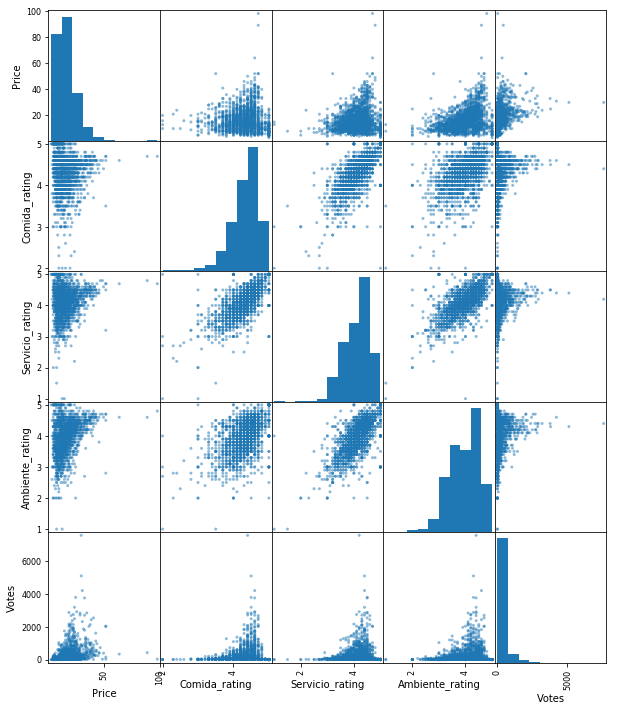

In [32]:
from pandas.plotting import scatter_matrix
attributes = ['Price', 'Comida_rating', 'Servicio_rating', 'Ambiente_rating', 'Votes']
scatter_matrix(city[attributes], figsize=(10,12))
0

We notice that reviews are left-skewed, so they tend to be fairly positive. All rating categories seem to be correlated with each other, which is expected. Votes is extremely right-skewed, due to a very small subset of popular restaurants. It'll be interesting to explore these.  Finally, we see that prices are also right-skewed. It is in our interest to remove the price outliers, because they'll affect the scale of our graphs.

In [33]:
city = city[~city['Price'].isnull()]
def remove_outliers(column, df):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df.query('(@Q1-1.5*@IQR) <= Price <= (@Q3+1.5*@IQR)').sort_values(column)
    return df
city = remove_outliers('Price', city)
city.shape[0]

1623

This leaves us with 1623 restaurants.

## Data Analysis and Visualization

First, I create a map of Panama City showing each restaurant as a dot. The color of each dot represents the price as reflected by the restaurant's Degusta profile. I want to see which areas have the most expensive restaurants.

In [34]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)  

In [35]:
city['text'] = city['Name'] + ', ' + city['Neighborhood'] +' ($' + city['Price'].astype(str) + ')'

def plot_map(df, column, title, colorbartitle, cmin):
    data = [ go.Scatter(
            x = city['Long'],
            y = city['Lat'],
            text = city['text'],
            mode = 'markers',
            hoverinfo=None,
            marker = dict( 
                size = 10, 
                opacity = 0.4,
                autocolorscale = False,
                symbol = 'circle',
                color = city[column],
                cmin = cmin,
                cmax = city[column].max(),
                colorbar=dict(
                    title=colorbartitle
                )
            ))]

    layout = dict(
            title = title,
            height=700,
            width=900,
            hovermode='closest',
            xaxis = dict(
                title= dict(
                    text='Longitude'
                ),
                fixedrange=True
            ),
            yaxis = dict(
                title= dict(
                    text='Latitude'
                ),
                fixedrange=True
            ),
            images=[dict(
                source='https://raw.githubusercontent.com/ejyap/GraphGallery/master/MapPanamaCity3.png',
                x=0, y=0,
                sizex=1, sizey=1,
                sizing='stretch',
                xanchor="left", yanchor="bottom",
                layer='below',
                opacity=0.7,
                visible=True
            )]
        )
    plotly.offline.iplot({'data': data, 'layout': layout})
plot_map(city, 'Price', 'Panama City Restaurant Map by Price', "Price (dollars)", 0)

It becomes instantly clear that Casco Antiguo, better known as Casco Viejo, has a high density of expensive restaurants. For those who know the city, this comes as no surprise. We also notice that the expensive restaurants are usually located near the coast, while cheaper restaurants are spread throughout the whole city.

I'd specifically like to know exactly which areas or neighborhoods have the high average price per restaurant. We get rid of neighborhoods that have less than 5 restaurants.

Text(0.5, 1.0, 'Average Restaurant Price for each Neighborhood')

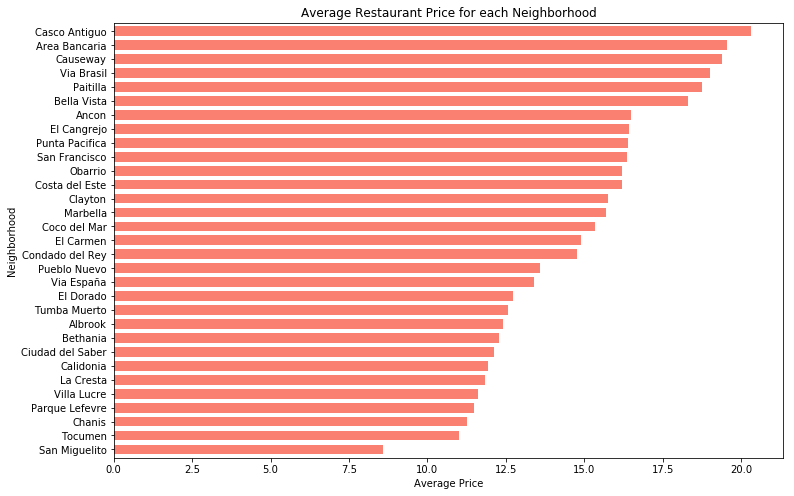

In [36]:
neigh = city.groupby('Neighborhood').filter(lambda x: len(x) >= 5)
neigh = neigh.groupby('Neighborhood')['Price'].mean().sort_values(ascending=True)
ax = neigh.plot.barh(figsize=(12,8), width=0.7, color='salmon')
ax.set_xlabel('Average Price')
ax.set_title('Average Restaurant Price for each Neighborhood')

San Miguelito, Tocumen, Chanis, Parque Lefevre, Villa Luque are the cheapest and they are all Northeastern areas located far from the city center. Casco Antiguo, Area Bancaria and Causeway are the most expensive areas. No surprise there.

As we saw earlier, rating scores are highly correlated with each other, so instead of exploring them individually, I will create a new score which is an aggregate of all the ratings. This new aggegate score will have a maximum of 15. 

count    1623.000000
mean       12.305176
std         1.258053
min         4.000000
25%        11.600000
50%        12.500000
75%        13.200000
max        15.000000
Name: Agg_rating, dtype: float64

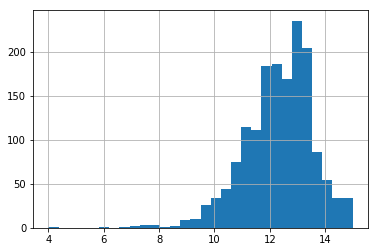

In [37]:
city['Agg_rating'] = city['Comida_rating'] + city['Servicio_rating'] + city['Ambiente_rating']
city['Agg_rating'].hist(bins=30)
city['Agg_rating'].describe()

We want to create a graph showing where the highest rated restaurants are, but most ratings are in the range of 10-15. We can see that a vast majority of the restaurants have good scores. We can interpret this as the restaurants in Panama City being very good, or the userbase is simply more prone to give positive reviews. We will limit the range to 10 to 15, in order to not mess up the scale of our colorbar and show meaningful ratings. We also want to get rid of restaurants that do not have more than 15 reviews, which I belive is a good number of samples.

In [38]:
city['agg_rating'] = city['Comida_rating'] + city['Servicio_rating'] + city['Ambiente_rating']
city = city[city['Votes'] > 15]
city['text'] = city['Name'] + ', ' + city['Neighborhood'] +' (' + city['Agg_rating'].astype(str).str[:5] + ')'
plot_map(city, 'Agg_rating', 'Panama City Restaurant Map by Score (Aggregate)', 'Aggregate Score', 10)

From looking at the graph, the city center seems to be filled with high-rated restaurants, but this might be due to the fact that there's simply more restaurants in that region. So, not only do we see a lot of high-rated restaurants, we also see a lot more medicore-rated restaurants.

We can calculate the mean rating of each Neighborhood in order to obtain a more accurate ranking.

In [39]:
rating = city.groupby('Neighborhood').filter(lambda x: len(x) >= 5)
rating = rating.groupby('Neighborhood')['Agg_rating'].mean().sort_values(ascending=False)
rating

Neighborhood
Coco del Mar        12.850000
Casco Antiguo       12.810714
Clayton             12.780952
Obarrio             12.740789
Costa del Este      12.622523
Bella Vista         12.475714
Area Bancaria       12.426316
San Francisco       12.410000
Marbella            12.330435
Punta Pacifica      12.271605
El Carmen           12.160000
Via Brasil          12.128571
El Cangrejo         12.110526
Parque Lefevre      12.088889
Condado del Rey     12.043210
Causeway            12.040000
Ancon               12.020000
Tumba Muerto        11.962500
Pueblo Nuevo        11.905882
Paitilla            11.737500
Bethania            11.727273
El Dorado           11.726923
Albrook             11.654687
Chanis              11.650000
Ciudad del Saber    11.521429
Via España          11.478261
Villa Lucre         11.016667
Name: Agg_rating, dtype: float64

Next, we can look at which types of restaurants are the most common in Panama City. Let's look at the Top 20

Text(0.5, 1.0, 'Top Restaurant Tags')

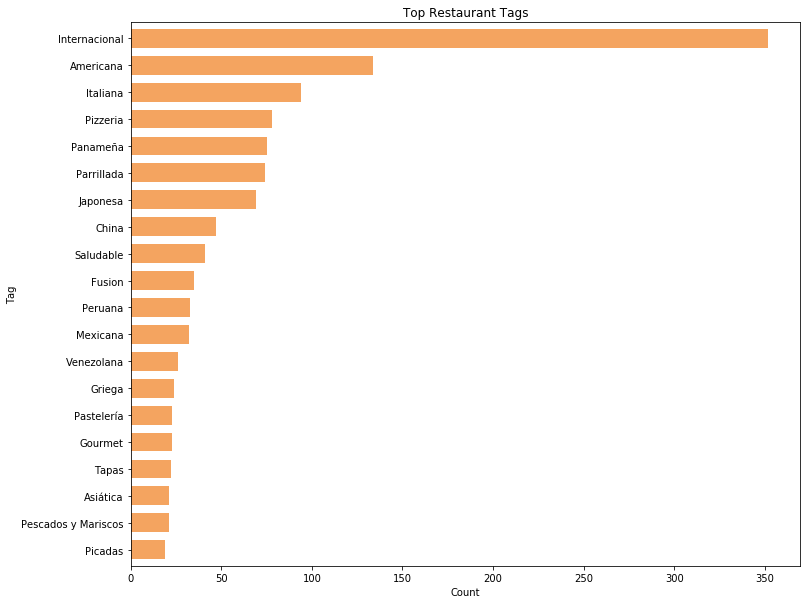

In [40]:
types = city['Type'].apply(lambda x: pd.Series(x).value_counts()).sum().sort_values().tail(20)
ax = types.plot.barh(figsize=(12,10), width=0.7, color='sandybrown')
ax.set_xlabel('Count')
ax.set_ylabel('Tag')
ax.set_title('Top Restaurant Tags')

Not really satisfied with the tags used for restaurants. 'International' is an umbrella term for various types of restaurants, which is probably why it's at the top. We also see tags such as 'Asiatica' exist, when there's already a category for more specific types of restaurants ('China', 'Japonesa'). 

Something more interesting would be to see which types of restaurants are the most expensive.

Text(0.5, 1.0, 'Prices per Restaurant Tag')

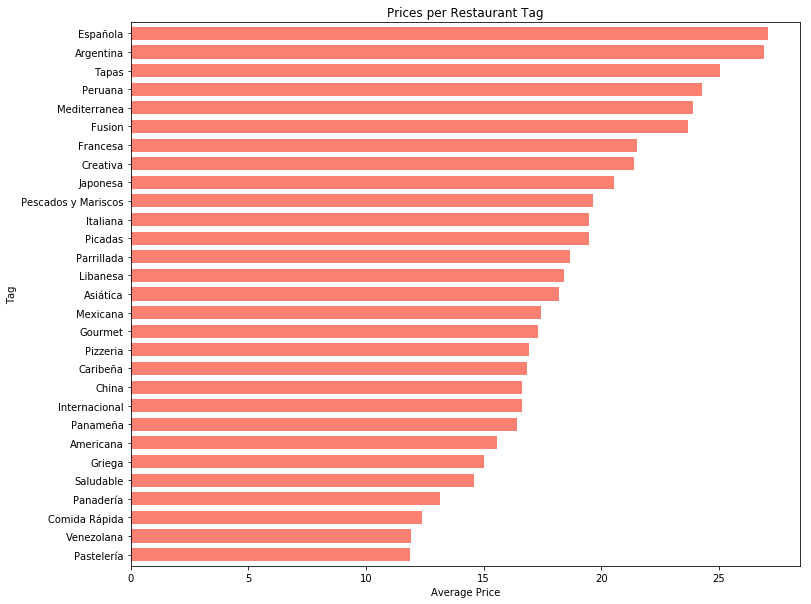

In [41]:
neigh_prices = city.Type.apply(pd.Series) \
    .merge(city, right_index = True, left_index = True) \
    .drop(['Type'], axis = 1) \
    .melt(id_vars = ['Name', 'Price'], value_vars=[0,1,2], value_name = 'Type') \
    .drop("variable", axis = 1) \
    .dropna()
neigh_prices = neigh_prices.groupby('Type').filter(lambda x: len(x) > 10) \
    .groupby('Type')['Price'] \
    .mean() \
    .sort_values()
ax = neigh_prices.plot.barh(figsize=(12,10), width=0.7, color='salmon')
ax.set_xlabel('Average Price')
ax.set_ylabel('Tag')
ax.set_title('Prices per Restaurant Tag')

Surprisingly, Argentinian and Spanish food are the most expensive, two types of cusines that I haven't had experience with before. Not surprisingly we find Cake shops, fast food and bakeries at the bottom.

Next, we want to see which restaurants have the most check-ins (most reviewed) and display it in map form. As we saw before, we have some few restaurants that have over 1000 reviews. We don't want to get rid of these outliers. Instead, what I'll do is graph a logarithmic version of the # of check-ins. 

In [42]:
city['text'] = city['Name'] + ', ' + city['Neighborhood'] +' (' + city['Votes'].astype(str).str[:5] + ' Check-ins)'
city['logvotes'] = city['Votes'].apply(lambda x: np.log(x))
plot_map(city, 'logvotes','Panama City Restaurant Map by # of Check-ins','Check-ins (Log)',0)

Text(0.5, 1.0, 'Check-In Count for each Neighborhood')

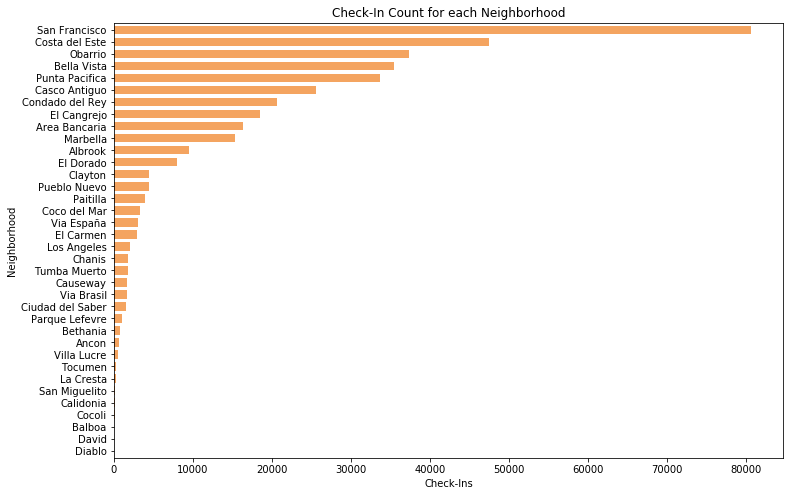

In [43]:
logvotes = city.groupby('Neighborhood')['Votes'].sum().sort_values(ascending=True)
ax = logvotes.plot.barh(figsize=(12,8), width=0.7, color='sandybrown')
ax.set_xlabel('Check-Ins')
ax.set_title('Check-In Count for each Neighborhood')

As we can see, the most checked-in restaurants are located in densley populated areas, which makes sense. San Francisco takes the top spot by a wide margin due to its large number of restaurants.

Finally, let's see which restaurants specifically have the most check-ins. Be sure to check these off your list if you're in Panama!

Text(0.5, 1.0, 'Top 20 Restaurants by # of Check-ins')

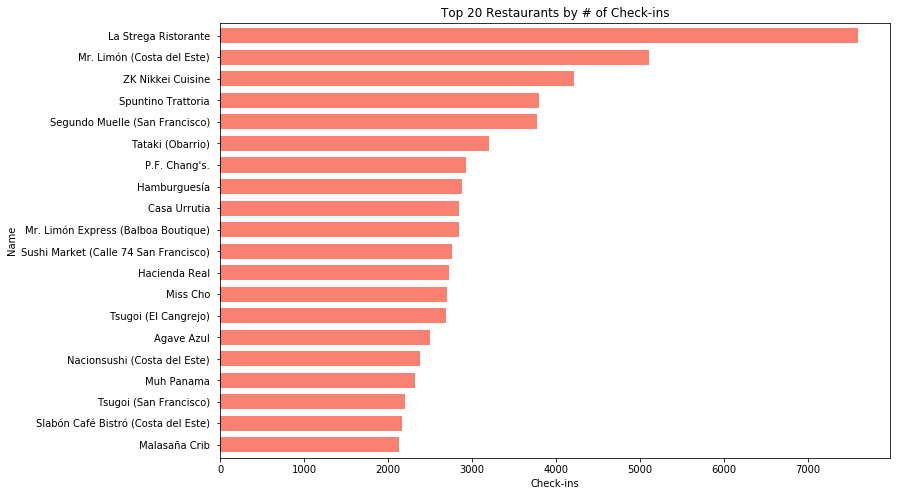

In [44]:
ax = city.sort_values('Votes').tail(20).plot.barh(x='Name', y='Votes', figsize=(12,8), width=0.7, color='salmon', legend=False)
ax.set_xlabel('Check-ins')
ax.set_title('Top 20 Restaurants by # of Check-ins')

In [55]:
city = city[city['Votes'] >= 100]

In [56]:
city['total_score'] = city['Comida_rating'] + city['Servicio_rating'] + city['Ambiente_rating']

c:\users\eduar\pycharmprojects\degustaanalysis\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000186F58F8588>]],
      dtype=object)

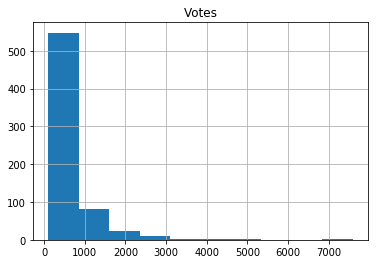

In [62]:
city.hist('Votes')

In [60]:
city.sort_values('total_score')

,Name,Type,Area,Neighborhood,Address,Lat,Long,Price,Comida_rating,Servicio_rating,...,Acceso_discapacitados,Estacionamientos,Kosher,Wifi,Domicilio,Dog_friendly,text,Agg_rating,logvotes,total_score
1572,The Buffalo House (San Francisco),[Americana],Panamá,San Francisco,Calle 50 y calle 77,8.992194,-79.502603,14.0,3.7,3.2,...,0,1,0,0,1,0,"The Buffalo House (San Francisco) , San Franci...",9.4,5.225747,9.4
1549,Papa John's (Costa del Este),"[Pizzeria, Americana]",Panamá,Costa del Este,"Ave. Centenario, CC Galerias del Este",9.017091,-79.463302,17.0,3.8,2.9,...,0,1,0,0,1,0,"Papa John's (Costa del Este) , Costa del Este ...",9.7,6.054439,9.7
1574,Wing Zone (El Dorado),[Americana],Panamá,El Dorado,"Via Ricardo J. Alfaro, Edif. Century Tower, Lo...",9.002963,-79.532760,14.0,3.7,2.9,...,1,1,0,0,1,0,"Wing Zone (El Dorado) , El Dorado (102Check-ins)",9.7,4.624973,9.7
1573,Rock Burger (Calle 50),[Americana],Panamá,San Francisco,"Plaza los Portales , Calle 50 y Calle 66",8.989680,-79.511340,14.0,3.7,3.3,...,1,1,0,0,1,0,"Rock Burger (Calle 50) , San Francisco (112Che...",10.0,4.718499,10.0
140,Niko's Café (Vía Israel),"[Internacional, Panameña]",Panamá,San Francisco,Vía Israel y Calle 50,8.988472,-79.511876,10.0,3.6,3.3,...,1,1,0,1,0,0,"Niko's Café (Vía Israel) , San Francisco (166C...",10.1,5.111988,10.1
643,Onze (San Francisco),[Saludable],Panamá,San Francisco,"Vía Israel, Centro Comercial Multimall",8.987608,-79.507724,12.0,3.9,3.2,...,0,1,0,0,0,0,"Onze (San Francisco) , San Francisco (226Check...",10.2,5.420535,10.2
114,Nandy's Grill (Betania),[Parrillada],Panamá,Bethania,"Av. La Paz con calle 74 oeste, El Ingenio",9.019885,-79.522637,10.0,4.1,3.3,...,0,1,0,0,1,0,"Nandy's Grill (Betania) , Bethania (113Check-ins)",10.3,4.727388,10.3
1990,Balboa Yacht Club,"[Americana, Pescados y Mariscos]",Panamá,Causeway,Primera calle a la derecha a un costado del Ho...,8.940627,-79.555445,21.0,3.2,3.2,...,1,1,0,1,0,0,"Balboa Yacht Club , Causeway (187Check-ins)",10.3,5.231109,10.3
1944,Tambor de Oro,[Peruana],Panamá,San Francisco,"Calle Fundadores, casa 68",8.990337,-79.504226,21.0,4.0,3.4,...,0,1,0,0,0,0,"Tambor de Oro , San Francisco (200Check-ins)",10.3,5.298317,10.3
1196,La Cevicheria Panama,"[Cevicheria, Internacional]",Panamá,Area Bancaria,"Calle 53, Obarrrio. Plaza Hi Tech.",8.982626,-79.521261,19.0,3.9,3.4,...,0,1,0,0,0,0,"La Cevicheria Panama , Area Bancaria (261Check...",10.4,5.564520,10.4


In [59]:
city

,Name,Type,Area,Neighborhood,Address,Lat,Long,Price,Comida_rating,Servicio_rating,...,Acceso_discapacitados,Estacionamientos,Kosher,Wifi,Domicilio,Dog_friendly,text,Agg_rating,logvotes,total_score
700,Rass (Casco Antiguo),[Internacional],Panamá,Casco Antiguo,"Calle 8 Este, Casa Morales",8.953098,-79.535634,5.0,3.7,3.5,...,0,0,0,0,0,0,"Rass (Casco Antiguo) , Casco Antiguo (137Check...",10.6,4.919981,10.6
509,La Michoacana (San Francisco),[Internacional],Panamá,San Francisco,"Calle 74, Via Israel",8.990591,-79.504858,5.0,4.2,3.9,...,1,1,0,0,0,0,"La Michoacana (San Francisco) , San Francisco ...",11.8,5.010635,11.8
391,Paleta House (Punta Pacifica),[Italiana],Panamá,Punta Pacifica,"Calle Punta Darién, Torres de Las Américas, Pl...",8.982871,-79.509484,5.0,4.4,4.1,...,1,1,0,1,0,0,"Paleta House (Punta Pacifica) , Punta Pacifica...",12.5,5.147494,12.5
12,Palettamerica (Casco Antiguo),[Internacional],Panamá,Casco Antiguo,Calle 8va frente a Tántalo,8.953174,-79.536827,5.0,4.7,4.5,...,1,0,0,1,0,0,"Palettamerica (Casco Antiguo) , Casco Antiguo ...",13.3,5.420535,13.3
443,La Michoacana (El Dorado),[Internacional],Panamá,El Dorado,Dorado Plaza Acuarela,9.005683,-79.540295,5.0,4.3,4.0,...,1,1,0,0,0,0,"La Michoacana (El Dorado) , El Dorado (139Chec...",11.9,4.934474,11.9
14,Palettamerica (San Francisco),[Internacional],Panamá,San Francisco,"Calle 71, con Calle los Fundadores",8.989751,-79.507657,5.0,4.7,4.5,...,1,0,0,0,0,0,"Palettamerica (San Francisco) , San Francisco ...",13.5,5.017280,13.5
102,Gelarti (Condado del Rey),[Internacional],Panamá,Condado del Rey,Plaza Green Park,9.028509,-79.525007,6.0,4.2,3.3,...,0,0,0,0,0,0,"Gelarti (Condado del Rey) , Condado del Rey (1...",11.3,4.700480,11.3
313,Ilgelato,"[Italiana, Heladería]",Panamá,San Francisco,"Calle 77, Bajando por Banistmo",8.992088,-79.501837,6.0,4.6,4.4,...,1,1,0,1,0,0,"Ilgelato , San Francisco (304Check-ins)",13.1,5.717028,13.1
11,Granclement,[Internacional],Panamá,Casco Antiguo,Calle 3era Oeste,8.952161,-79.533688,6.0,4.7,3.8,...,0,0,0,1,0,0,"Granclement , Casco Antiguo (243Check-ins)",12.2,5.493061,12.2
4,Helados Keene's,[Internacional],Panamá,San Francisco,"Calle 67, Frente al Clean and Clean",8.993484,-79.511769,6.0,4.8,4.6,...,0,0,0,0,1,0,"Helados Keene's , San Francisco (231Check-ins)",13.4,5.442418,13.4


In [94]:
data = [go.Scatter(
            x = city[city['Neighborhood'] == neigh]['total_score'],
            y = city[city['Neighborhood'] == neigh]['Price'],
            text = city[city['Neighborhood'] == neigh]['text'],
            mode = 'markers',
            hoverinfo=None,
            name = neigh,
            marker = dict( 
                size = city[city['Neighborhood'] == neigh]['Votes'], 
                sizemode='area',
                sizeref=max(city[city['Neighborhood'] == neigh]['Votes'])/(40.**2),
                sizemin=4,
                opacity = 0.4,
                autocolorscale = False,
                symbol = 'circle'
            )) for neigh in city['Neighborhood'].value_counts().index]

layout = dict(title = 'Price vs. Rating',
            hovermode='closest',
            height=900,
            width=900,
            xaxis = dict(
                title= dict(
                    text='Total Score (out of 15)'
                ),
                fixedrange=True
            ),
            yaxis = dict(
                title= dict(
                    text='Average Price (dollars)'
                ),
                fixedrange=True
            )
            )

plotly.offline.iplot({'data': data, 'layout': layout})

In [73]:
city['Neighborhood'].value_counts()

San Francisco       125
Costa del Este       76
Casco Antiguo        57
Bella Vista          51
Punta Pacifica       50
Condado del Rey      46
Obarrio              43
El Cangrejo          37
Area Bancaria        28
Marbella             25
El Dorado            24
Albrook              23
Paitilla             11
Via España           10
Clayton               8
Pueblo Nuevo          7
El Carmen             6
Coco del Mar          5
Tumba Muerto          5
Bethania              4
Via Brasil            4
Causeway              4
Chanis                3
Ciudad del Saber      3
Ancon                 3
Tocumen               2
Parque Lefevre        2
Villa Lucre           1
Los Angeles           1
Cocoli                1
San Miguelito         1
Calidonia             1
Name: Neighborhood, dtype: int64